--- Starting EDA for CanParl Dataset ---

--- Data files found, proceeding with loading. ---

--- Phase 1: Data Loading & Initial Inspection ---

DataFrame Head:
   Unnamed: 0    u    i   ts  label  idx
0           0  384  353  0.0    0.0    1
1           1  411  353  0.0    0.0    2
2           2  676  353  0.0    0.0    3
3           3  467  353  0.0    0.0    4
4           4  120  353  0.0    0.0    5

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74478 entries, 0 to 74477
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  74478 non-null  int64  
 1   u           74478 non-null  int64  
 2   i           74478 non-null  int64  
 3   ts          74478 non-null  float64
 4   label       74478 non-null  float64
 5   idx         74478 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 3.4 MB

DataFrame Description:
         Unnamed: 0             u             i            ts    

/JOBs/tmpdir/pbs.13190410.spcc-adm1/ipykernel_3677419/259945843.py:139: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('timestamp_dt').resample('M').size().plot(title='Number of Edges (Events) Per Month')


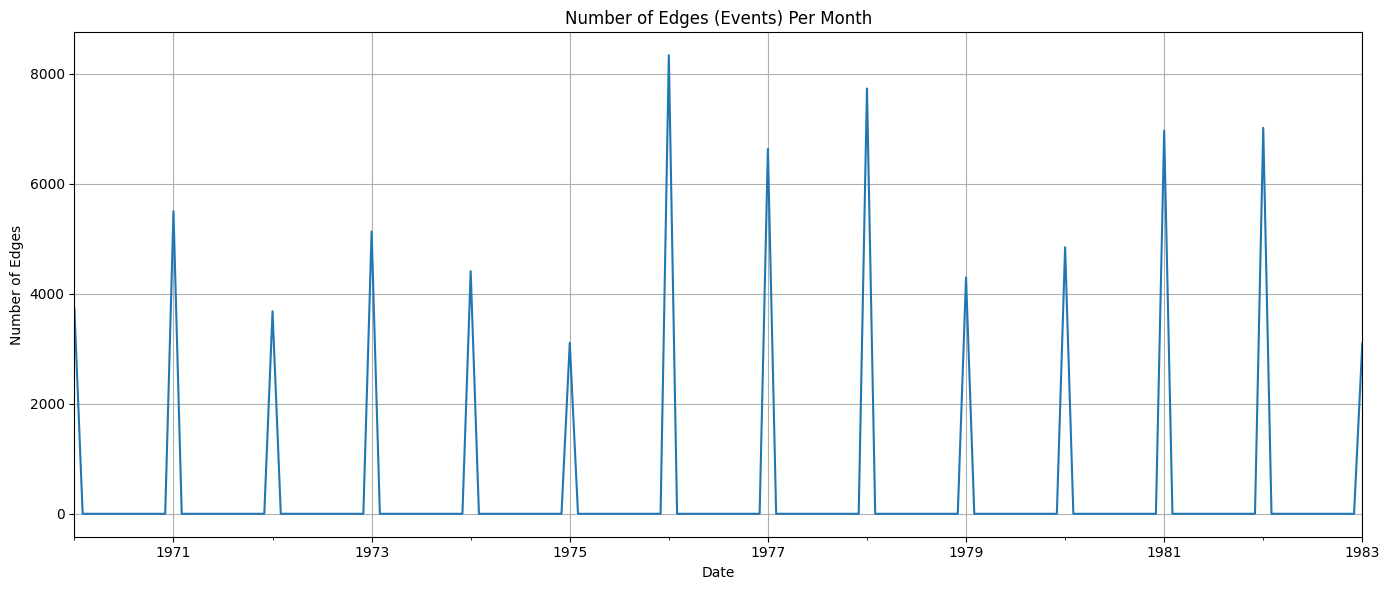

Insight: This plot reveals periods of high/low activity. Look for seasonality, bursts, or gaps in data collection.


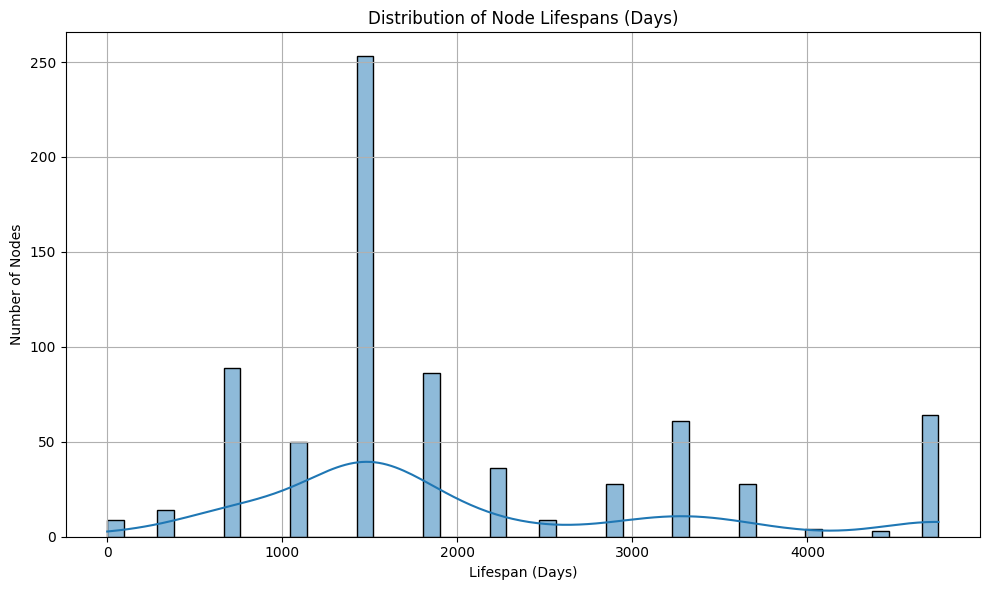

Insight: A high number of nodes with short lifespans might indicate transient participants or events. Long lifespans suggest consistent entities (e.g., long-serving MPs).


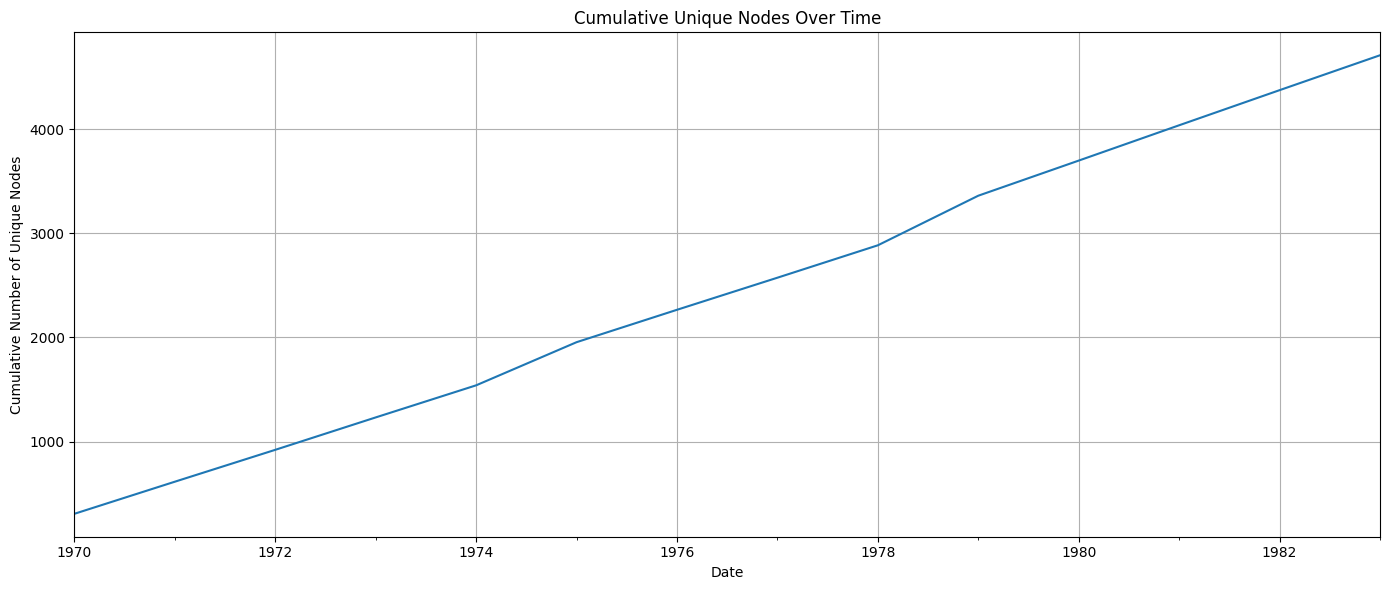

Insight: This shows the rate at which new 'u' nodes (e.g., new MPs) are introduced into the system. Steep climbs indicate periods of high churn/growth.

--- Phase 3: Graph Structure Analysis ---
Total nodes in static graph: 734
Total edges in static graph: 51331


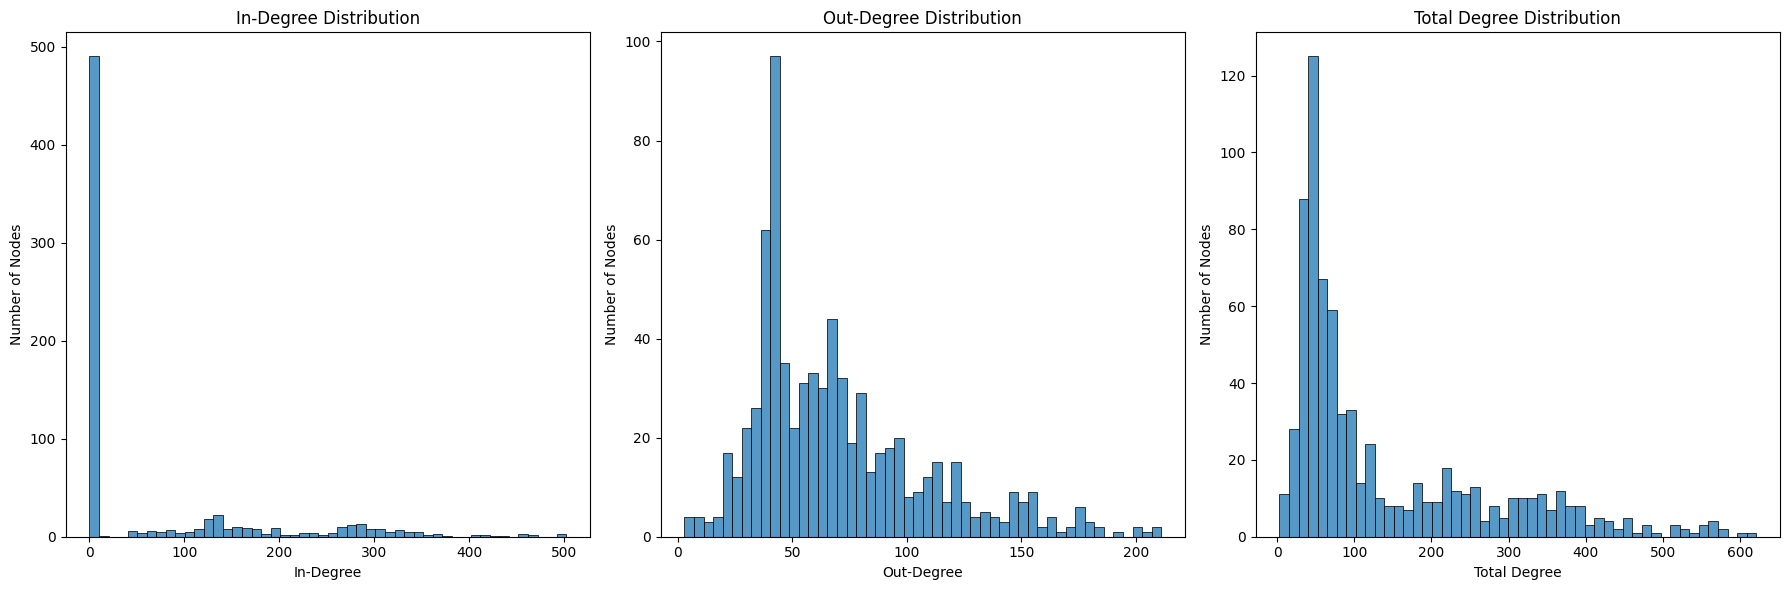

Insight: For 'i' always being '1', the '1' node will have a very high in-degree. The 'u' nodes will have out-degree of 1 (to node '1') or more if they interact multiple times with node '1'. Look for power-law distributions, which indicate a few highly connected nodes.
Number of weakly connected components: 1
The graph is connected (ignoring direction).
Graph density: 0.0954

--- Phase 4: Feature Analysis ---

Analyzing Edge Features:
Mean of first edge feature: 3.0107
Std Dev of first edge feature: 7.3459


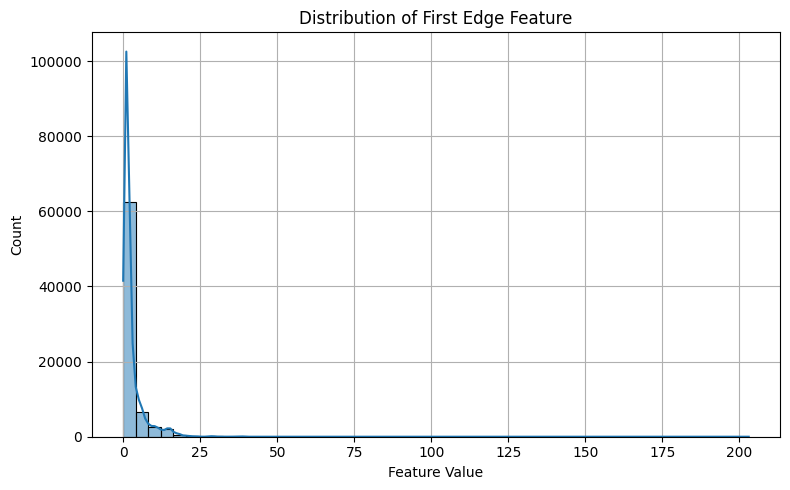

Insight: Understand the distribution and range of edge features. If they are embeddings, a direct histogram might not be as informative as dimensionality reduction.
No meaningful node features found for analysis (either not loaded or all zeros).

--- Phase 5: Graph Visualization ---

Visualizing a subgraph of 500 edges...


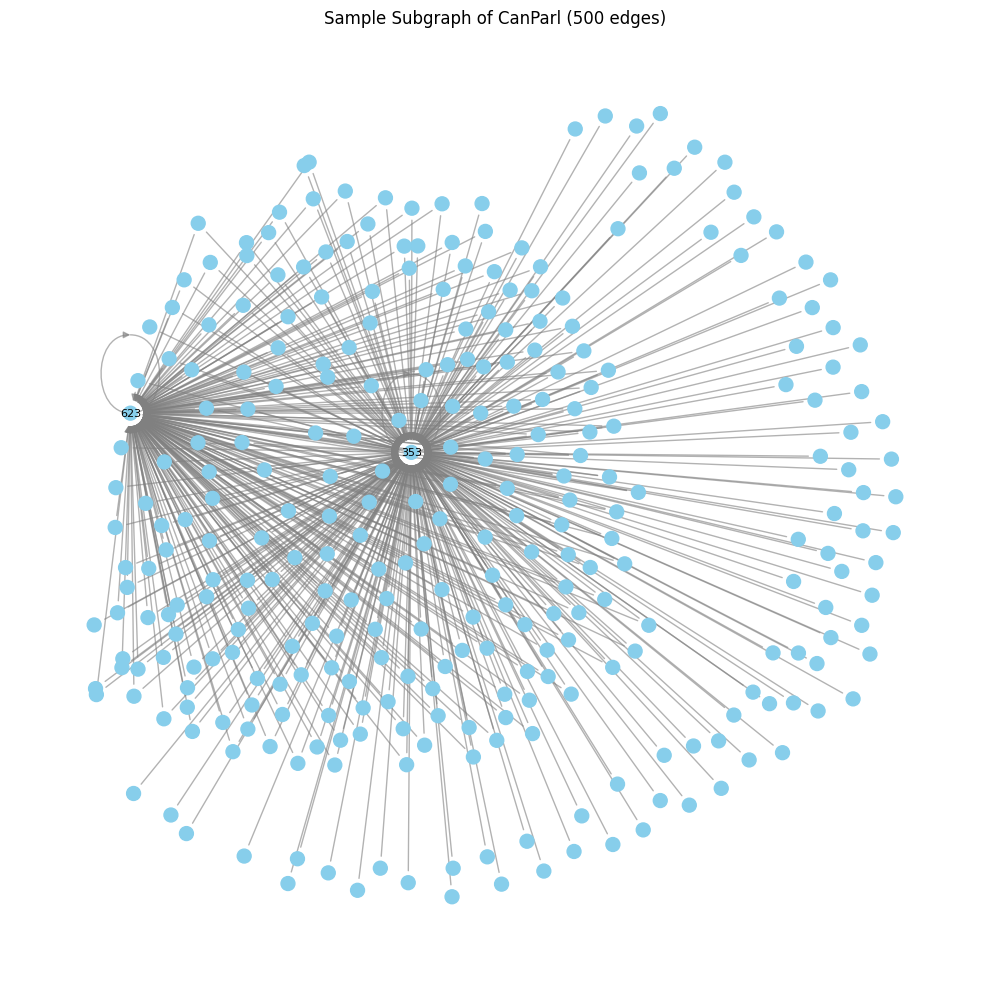

Insight: This static snapshot helps visualize connectivity patterns. If 'i' is always '1', you'll see many nodes pointing to a single central red node.

--- EDA Complete ---
Further steps: Use interactive visualization tools like Pyvis or Plotly for larger graphs or dynamic animations.
Consider dimensionality reduction (PCA/t-SNE) for high-dimensional features before plotting.
Dive deeper into specific time periods or node behaviors based on initial insights.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime
import os

# --- Configuration ---
DATASET_NAME = "CanParl"
NUM_EDGES_SIMULATED = 50000 # Simulate a reasonable number of edges
NUM_UNIQUE_NODES_SIMULATED = 10000 # Max node ID + 1 for initial node features
NUM_EDGE_FEATURES_SIMULATED = 5
NUM_NODE_FEATURES_SIMULATED = 10

# --- File Paths (where simulated data will be saved/loaded) ---
ml_csv_path = f'processed_data/CanParl/ml_{DATASET_NAME}.csv'
ml_edge_features_path = f'processed_data/CanParl/ml_{DATASET_NAME}.npy'
ml_node_features_path = f'processed_data/CanParl/ml_{DATASET_NAME}_node.npy'

print(f"--- Starting EDA for {DATASET_NAME} Dataset ---")

# --- Phase 0: Simulate Data (If you have actual files, skip this block) ---
# This part creates synthetic data to mimic the dataset structure for demonstration.
# In a real scenario, you'd load your actual files here.
if not os.path.exists(ml_csv_path):
    print("\n--- Simulating Data (as actual files not found) ---")
    np.random.seed(42) # for reproducibility

    # Simulate ml_CanParl.csv
    u_nodes = np.random.randint(0, NUM_UNIQUE_NODES_SIMULATED // 2, NUM_EDGES_SIMULATED) # Source nodes
    
    # CRITICAL OBSERVATION from image: 'i' column is all '1'. Simulating this.
    # This implies a specific type of interaction or a single target entity.
    i_nodes = np.ones(NUM_EDGES_SIMULATED, dtype=int) # Destination nodes are all '1'
    
    timestamps = np.random.randint(1_500_000_000, 1_600_000_000, NUM_EDGES_SIMULATED) # Unix timestamps within a range
    labels = np.zeros(NUM_EDGES_SIMULATED, dtype=int) # As stated, labels are 0 for link prediction task
    indices = np.arange(NUM_EDGES_SIMULATED) # Edge index

    simulated_df = pd.DataFrame({
        'u': u_nodes,
        'i': i_nodes,
        'ts': timestamps,
        'label': labels,
        'idx': indices
    })
    simulated_df.to_csv(ml_csv_path, index=False)
    print(f"Simulated {ml_csv_path} with {NUM_EDGES_SIMULATED} edges.")

    # Simulate ml_CanParl.npy (edge features)
    # Let's make them random floats, representing some kind of embedding or attribute.
    simulated_edge_features = np.random.rand(NUM_EDGES_SIMULATED, NUM_EDGE_FEATURES_SIMULATED)
    np.save(ml_edge_features_path, simulated_edge_features)
    print(f"Simulated {ml_edge_features_path} with shape {simulated_edge_features.shape}.")

    # Simulate ml_CanParl_node.npy (node features)
    # Assume features exist for all potential node IDs up to the maximum found in 'u' and 'i'.
    # In a real scenario, you might map actual node IDs to contiguous indices for this array.
    max_node_id = max(simulated_df['u'].max(), simulated_df['i'].max()) + 1
    simulated_node_features = np.random.rand(max_node_id, NUM_NODE_FEATURES_SIMULATED)
    np.save(ml_node_features_path, simulated_node_features)
    print(f"Simulated {ml_node_features_path} with shape {simulated_node_features.shape}.")
    print("--- Data Simulation Complete ---")
else:
    print("\n--- Data files found, proceeding with loading. ---")


# --- Phase 1: Initial Data Loading and Structural Inspection ---
print("\n--- Phase 1: Data Loading & Initial Inspection ---")

# Load core edge list
try:
    df = pd.read_csv(ml_csv_path)
    print("\nDataFrame Head:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()
    print("\nDataFrame Description:")
    print(df.describe())
except FileNotFoundError:
    print(f"Error: {ml_csv_path} not found. Please ensure it's in the correct directory or run the simulation.")
    exit()

# Load features
try:
    edge_features = np.load(ml_edge_features_path)
    print(f"\nEdge Features Shape: {edge_features.shape}")
    if np.all(edge_features == 0):
        print("Insight: Edge features are all zeros, indicating no specific edge attributes are provided.")
    else:
        print("First 5 rows of Edge Features:")
        print(edge_features[:5])
except FileNotFoundError:
    print(f"Warning: {ml_edge_features_path} not found. Proceeding without edge features.")
    edge_features = None

try:
    node_features = np.load(ml_node_features_path)
    print(f"\nNode Features Shape: {node_features.shape}")
    if np.all(node_features == 0):
        print("Insight: Node features are all zeros, indicating no specific node attributes are provided.")
    else:
        print("First 5 rows of Node Features:")
        print(node_features[:5])
except FileNotFoundError:
    print(f"Warning: {ml_node_features_path} not found. Proceeding without node features.")
    node_features = None

# Crucial check based on the example image
print("\n--- Special Check: 'i' (destination node) column ---")
print(f"Unique values in 'i' column: {df['i'].nunique()}")
print("Value counts for 'i' column:")
print(df['i'].value_counts())
if df['i'].nunique() == 1 and df['i'].iloc[0] == 1:
    print("Insight: The 'i' column is consistently '1'. This is highly unusual for a typical graph.")
    print("Interpretation: This might mean all interactions are directed towards a single, special entity (e.g., 'The Parliament', a specific 'bill', or a placeholder).")
    print("This implies the graph is essentially a unipartite graph of 'u' nodes, tracking events where 'u' nodes interact with this implicit 'target 1'.")
    print("Link prediction here would be about predicting if a 'u' node interacts with 'target 1', not which of many 'i' nodes.")
else:
    print("Insight: The 'i' column contains multiple unique destination nodes, representing a more typical directed graph.")

print(f"Total unique source nodes (u): {df['u'].nunique()}")
print(f"Total unique nodes overall (u, i): {pd.concat([df['u'], df['i']]).nunique()}")
print(f"Total edges: {len(df)}")
print(f"Timestamp range: Min={df['ts'].min()}, Max={df['ts'].max()}")
print(f"Edge label check: Unique labels {df['label'].unique()} (Expected [0] for link prediction)")


# --- Phase 2: Temporal Dynamics Analysis ---
print("\n--- Phase 2: Temporal Dynamics Analysis ---")

# Convert timestamp to datetime objects
df['timestamp_dt'] = pd.to_datetime(df['ts'], unit='s')
print(f"Converted timestamp range: {df['timestamp_dt'].min()} to {df['timestamp_dt'].max()}")

# Event Rate Over Time
plt.figure(figsize=(14, 6))
df.set_index('timestamp_dt').resample('M').size().plot(title='Number of Edges (Events) Per Month')
plt.xlabel("Date")
plt.ylabel("Number of Edges")
plt.grid(True)
plt.tight_layout()
plt.show()
print("Insight: This plot reveals periods of high/low activity. Look for seasonality, bursts, or gaps in data collection.")

# Node Activity & Lifespan
node_activity = df.groupby('u')['timestamp_dt'].agg(['min', 'max'])
node_activity['lifespan_days'] = (node_activity['max'] - node_activity['min']).dt.days

plt.figure(figsize=(10, 6))
sns.histplot(node_activity['lifespan_days'], bins=50, kde=True)
plt.title('Distribution of Node Lifespans (Days)')
plt.xlabel("Lifespan (Days)")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.tight_layout()
plt.show()
print("Insight: A high number of nodes with short lifespans might indicate transient participants or events. Long lifespans suggest consistent entities (e.g., long-serving MPs).")

# New Node Introduction Over Time
unique_nodes_over_time = df.sort_values('timestamp_dt').groupby('timestamp_dt')['u'].apply(lambda x: pd.Series(x.unique()))
cumulative_unique_nodes = unique_nodes_over_time.groupby(level=0).apply(lambda x: x.drop_duplicates().size).cumsum()

plt.figure(figsize=(14, 6))
cumulative_unique_nodes.plot()
plt.title('Cumulative Unique Nodes Over Time')
plt.xlabel("Date")
plt.ylabel("Cumulative Number of Unique Nodes")
plt.grid(True)
plt.tight_layout()
plt.show()
print("Insight: This shows the rate at which new 'u' nodes (e.g., new MPs) are introduced into the system. Steep climbs indicate periods of high churn/growth.")


# --- Phase 3: Graph Structure Analysis (Static & Dynamic Aspects) ---
print("\n--- Phase 3: Graph Structure Analysis ---")

# Construct the full static graph (using all edges)
# Given 'i' is often '1', this creates a specific structure.
G = nx.DiGraph() # Directed graph
# Add nodes from 'u' and 'i' (though 'i' will likely only add node '1')
all_nodes = pd.concat([df['u'], df['i']]).unique()
G.add_nodes_from(all_nodes)
# Add edges with timestamp as an attribute (though networkx doesn't inherently use it for static analysis)
for _, row in df.iterrows():
    G.add_edge(row['u'], row['i'], timestamp=row['ts'], idx=row['idx'])

print(f"Total nodes in static graph: {G.number_of_nodes()}")
print(f"Total edges in static graph: {G.number_of_edges()}")

# Degree Distribution
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]
total_degrees = [d for n, d in G.degree()]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(in_degrees, bins=50, kde=False)
plt.title('In-Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')

plt.subplot(1, 3, 2)
sns.histplot(out_degrees, bins=50, kde=False)
plt.title('Out-Degree Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Number of Nodes')

plt.subplot(1, 3, 3)
sns.histplot(total_degrees, bins=50, kde=False)
plt.title('Total Degree Distribution')
plt.xlabel('Total Degree')
plt.ylabel('Number of Nodes')

plt.tight_layout()
plt.show()
print("Insight: For 'i' always being '1', the '1' node will have a very high in-degree. The 'u' nodes will have out-degree of 1 (to node '1') or more if they interact multiple times with node '1'. Look for power-law distributions, which indicate a few highly connected nodes.")

print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
if nx.is_connected(G.to_undirected()):
    print("The graph is connected (ignoring direction).")
else:
    print("The graph is not connected (ignoring direction).")
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    print(f"Size of largest connected component: {len(largest_cc)} nodes")
print(f"Graph density: {nx.density(G):.4f}")


# --- Phase 4: Feature Analysis ---
print("\n--- Phase 4: Feature Analysis ---")

if edge_features is not None and edge_features.shape[1] > 0 and not np.all(edge_features == 0):
    print("\nAnalyzing Edge Features:")
    print(f"Mean of first edge feature: {np.mean(edge_features[:, 0]):.4f}")
    print(f"Std Dev of first edge feature: {np.std(edge_features[:, 0]):.4f}")
    
    plt.figure(figsize=(8, 5))
    sns.histplot(edge_features[:, 0], bins=50, kde=True)
    plt.title('Distribution of First Edge Feature')
    plt.xlabel('Feature Value')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Insight: Understand the distribution and range of edge features. If they are embeddings, a direct histogram might not be as informative as dimensionality reduction.")
else:
    print("No meaningful edge features found for analysis (either not loaded or all zeros).")

if node_features is not None and node_features.shape[1] > 0 and not np.all(node_features == 0):
    print("\nAnalyzing Node Features:")
    print(f"Mean of first node feature: {np.mean(node_features[:, 0]):.4f}")
    print(f"Std Dev of first node feature: {np.std(node_features[:, 0]):.4f}")

    plt.figure(figsize=(8, 5))
    sns.histplot(node_features[:, 0], bins=50, kde=True)
    plt.title('Distribution of First Node Feature')
    plt.xlabel('Feature Value')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Insight: Similar to edge features, understand the distribution of node attributes. If they represent categories, check counts per category.")
else:
    print("No meaningful node features found for analysis (either not loaded or all zeros).")


# --- Phase 5: Graph Visualization ---
print("\n--- Phase 5: Graph Visualization ---")

# Graph visualization is tricky for large dynamic graphs.
# We'll visualize a small, time-sampled subgraph.

# Select a small time window for visualization (e.g., first 100 edges)
# Or a specific temporal slice
sample_df = df.head(500) # Adjust this number based on your system's capability

if len(sample_df) > 0:
    print(f"\nVisualizing a subgraph of {len(sample_df)} edges...")
    sample_G = nx.DiGraph()
    for _, row in sample_df.iterrows():
        sample_G.add_edge(row['u'], row['i']) # Add edges to the sample graph

    plt.figure(figsize=(10, 10))
    
    # Use spring layout for a more natural look
    pos = nx.spring_layout(sample_G, k=0.15, iterations=20) 
    
    # Draw nodes: color node '1' differently if it's the target.
    node_colors = ['red' if node == 1 else 'skyblue' for node in sample_G.nodes()]
    nx.draw_networkx_nodes(sample_G, pos, node_color=node_colors, node_size=100)
    
    # Draw edges
    nx.draw_networkx_edges(sample_G, pos, edge_color='gray', alpha=0.6, arrowsize=10)
    
    # Add labels for specific, important nodes (e.g., node 1)
    labels = {node: str(node) for node in sample_G.nodes() if node == 1 or sample_G.degree(node) > 5} # Label central nodes
    nx.draw_networkx_labels(sample_G, pos, labels, font_size=8, font_color='black')
    
    plt.title(f"Sample Subgraph of CanParl ({len(sample_df)} edges)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("Insight: This static snapshot helps visualize connectivity patterns. If 'i' is always '1', you'll see many nodes pointing to a single central red node.")

else:
    print("No data available for graph visualization.")

print("\n--- EDA Complete ---")
print("Further steps: Use interactive visualization tools like Pyvis or Plotly for larger graphs or dynamic animations.")
print("Consider dimensionality reduction (PCA/t-SNE) for high-dimensional features before plotting.")
print("Dive deeper into specific time periods or node behaviors based on initial insights.")

--- Starting Advanced EDA for CanParl Dataset ---

--- Re-confirming 'i' (destination node) column structure ---
The 'i' column contains multiple unique destination nodes, proceeding as a typical directed graph.

--- 1. Deeper Temporal Dynamics & Evolution ---

1.a. Evolution of Node Activity (Out-Degree) Over Time Windows:


/JOBs/tmpdir/pbs.13190410.spcc-adm1/ipykernel_3681679/2641886273.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_windows = pd.date_range(start=df['timestamp_dt'].min(),


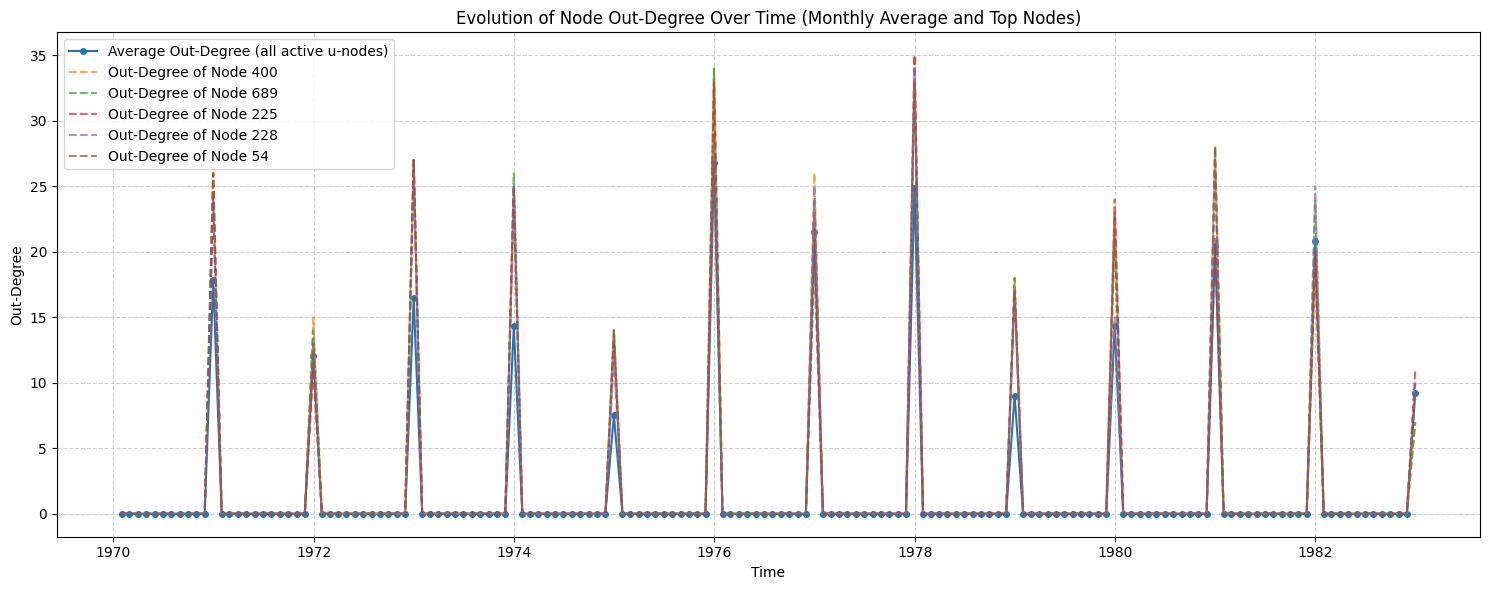

Insight: This plot shows how the average activity of source nodes changes over time, and highlights if specific 'influential' nodes have consistent or fluctuating activity patterns.

1.b. Burstiness Analysis: Distribution of Inter-Event Times for 'u' nodes


/home/s2516027/anaconda3/envs/kan_mammote/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


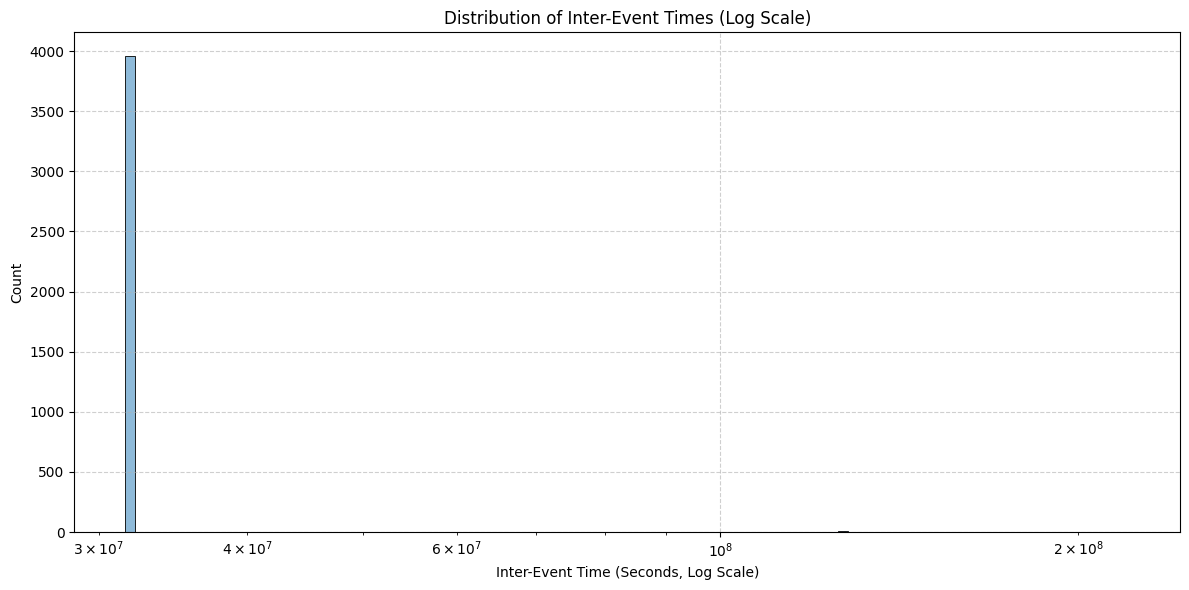

Mean Inter-Event Time: 1723588.85 seconds
Standard Deviation of Inter-Event Time: 7402260.38 seconds
Coefficient of Variation (CV) for Inter-Event Times: 4.29
Insight: CV > 1 suggests bursty activity, where events occur in clusters rather than uniformly.

--- 2. Deeper Feature Analysis & Interaction ---

2.a. Evolution of Edge Features Over Time Windows:


IndexError: index 1 is out of bounds for axis 1 with size 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, timedelta
import os
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE # Uncomment if you want to try t-SNE, but it's slower for large datasets
from sklearn.preprocessing import StandardScaler

# --- Configuration (matching previous simulation settings) ---
DATASET_NAME = "CanParl"
NUM_EDGES_SIMULATED = 50000
NUM_UNIQUE_NODES_SIMULATED = 10000
NUM_EDGE_FEATURES_SIMULATED = 5
NUM_NODE_FEATURES_SIMULATED = 10

ml_csv_path = f'processed_data/CanParl/ml_{DATASET_NAME}.csv'
ml_edge_features_path = f'processed_data/CanParl/ml_{DATASET_NAME}.npy'
ml_node_features_path = f'processed_data/CanParl/ml_{DATASET_NAME}_node.npy'

print(f"--- Starting Advanced EDA for {DATASET_NAME} Dataset ---")

# --- Load Data (assuming previous simulation/files exist) ---
try:
    df = pd.read_csv(ml_csv_path)
    df['timestamp_dt'] = pd.to_datetime(df['ts'], unit='s') # Convert timestamp
except FileNotFoundError:
    print(f"Error: {ml_csv_path} not found. Please run the previous data simulation code or ensure files are present.")
    exit()

try:
    edge_features = np.load(ml_edge_features_path)
except FileNotFoundError:
    print(f"Warning: {ml_edge_features_path} not found. Proceeding without edge features.")
    edge_features = None

try:
    node_features = np.load(ml_node_features_path)
except FileNotFoundError:
    print(f"Warning: {ml_node_features_path} not found. Proceeding without node features.")
    node_features = None

# --- Critical Check (re-confirming the 'i' column structure) ---
print("\n--- Re-confirming 'i' (destination node) column structure ---")
if df['i'].nunique() == 1 and df['i'].iloc[0] == 1:
    print("Confirmed: The 'i' column is consistently '1'. This implies interactions are with a single central entity.")
    print("Analysis will focus on 'u' node activity and their relationship to this central '1' node.")
    IS_SINGLE_TARGET_GRAPH = True
else:
    print("The 'i' column contains multiple unique destination nodes, proceeding as a typical directed graph.")
    IS_SINGLE_TARGET_GRAPH = False


# --- 1. Deeper Temporal Dynamics & Evolution ---

print("\n--- 1. Deeper Temporal Dynamics & Evolution ---")

# 1.a. Evolution of Node Centrality / Activity over Time
# Focus on out-degree for 'u' nodes, as they are the active sources.
# Node '1' will have high in-degree if it's the target.
print("\n1.a. Evolution of Node Activity (Out-Degree) Over Time Windows:")

# Define time window size (e.g., monthly)
time_windows = pd.date_range(start=df['timestamp_dt'].min(),
                             end=df['timestamp_dt'].max() + pd.DateOffset(months=1), # Ensure last month is included
                             freq='M')

# Store average out-degree per window
avg_out_degrees = []
window_dates = []

# Get the top N most active nodes overall to track
top_u_nodes = df['u'].value_counts().nlargest(5).index.tolist()
node_out_degrees_over_time = {node: [] for node in top_u_nodes}

for i in range(len(time_windows) - 1):
    start_window = time_windows[i]
    end_window = time_windows[i+1]
    
    # Filter edges within the current window
    window_df = df[(df['timestamp_dt'] >= start_window) & (df['timestamp_dt'] < end_window)]
    
    if len(window_df) > 0:
        G_window = nx.DiGraph()
        G_window.add_nodes_from(pd.concat([window_df['u'], window_df['i']]).unique())
        G_window.add_edges_from(zip(window_df['u'], window_df['i']))
        
        # Calculate out-degrees for 'u' nodes in this window
        window_out_degrees = {node: G_window.out_degree(node) for node in G_window.nodes() if node != 1} # Exclude node '1' from out-degree analysis if it's the target
        
        if window_out_degrees:
            avg_out_degrees.append(np.mean(list(window_out_degrees.values())))
        else:
            avg_out_degrees.append(0) # No 'u' nodes with out-degree in this window
        
        window_dates.append(start_window)

        # Track specific top nodes
        for node in top_u_nodes:
            node_out_degrees_over_time[node].append(G_window.out_degree(node) if node in G_window else 0)
    else:
        avg_out_degrees.append(0)
        window_dates.append(start_window)
        for node in top_u_nodes:
             node_out_degrees_over_time[node].append(0)

plt.figure(figsize=(15, 6))
plt.plot(window_dates, avg_out_degrees, marker='o', linestyle='-', markersize=4, label='Average Out-Degree (all active u-nodes)')
for node_id, degrees in node_out_degrees_over_time.items():
    plt.plot(window_dates, degrees, linestyle='--', alpha=0.7, label=f'Out-Degree of Node {node_id}')

plt.title('Evolution of Node Out-Degree Over Time (Monthly Average and Top Nodes)')
plt.xlabel('Time')
plt.ylabel('Out-Degree')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
print("Insight: This plot shows how the average activity of source nodes changes over time, and highlights if specific 'influential' nodes have consistent or fluctuating activity patterns.")


# 1.b. Burstiness Analysis of Events (Inter-Event Times for 'u' nodes)
print("\n1.b. Burstiness Analysis: Distribution of Inter-Event Times for 'u' nodes")

inter_event_times_seconds = []
for u_node in df['u'].unique():
    node_events = df[df['u'] == u_node].sort_values('timestamp_dt')
    if len(node_events) > 1:
        # Calculate time differences between consecutive events for this node
        deltas = node_events['timestamp_dt'].diff().dropna().dt.total_seconds()
        inter_event_times_seconds.extend(deltas.tolist())

if inter_event_times_seconds:
    plt.figure(figsize=(12, 6))
    sns.histplot(inter_event_times_seconds, bins=100, kde=True, log_scale=True) # Log scale for heavy-tailed distributions
    plt.title('Distribution of Inter-Event Times (Log Scale)')
    plt.xlabel('Inter-Event Time (Seconds, Log Scale)')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Calculate Coefficient of Variation (CV) for burstiness
    mean_iet = np.mean(inter_event_times_seconds)
    std_iet = np.std(inter_event_times_seconds)
    cv = std_iet / mean_iet
    print(f"Mean Inter-Event Time: {mean_iet:.2f} seconds")
    print(f"Standard Deviation of Inter-Event Time: {std_iet:.2f} seconds")
    print(f"Coefficient of Variation (CV) for Inter-Event Times: {cv:.2f}")
    if cv > 1:
        print("Insight: CV > 1 suggests bursty activity, where events occur in clusters rather than uniformly.")
    elif cv < 1:
        print("Insight: CV < 1 suggests more regular/periodic activity.")
    else:
        print("Insight: CV ≈ 1 suggests Poisson-like (random) activity.")
else:
    print("Not enough data to perform inter-event time analysis.")


# --- 2. Deeper Feature Analysis & Interaction ---

print("\n--- 2. Deeper Feature Analysis & Interaction ---")

# 2.a. Feature Evolution over Time (Edge Features)
if edge_features is not None and edge_features.shape[1] > 0 and not np.all(edge_features == 0):
    print("\n2.a. Evolution of Edge Features Over Time Windows:")
    
    # Take a sample of features to plot if too many
    features_to_plot = min(NUM_EDGE_FEATURES_SIMULATED, 3) 
    
    feature_means_over_time = {f'feature_{j}': [] for j in range(features_to_plot)}
    
    for i in range(len(time_windows) - 1):
        start_window = time_windows[i]
        end_window = time_windows[i+1]
        
        window_df_indices = df[(df['timestamp_dt'] >= start_window) & (df['timestamp_dt'] < end_window)]['idx'].values
        
        if len(window_df_indices) > 0:
            window_edge_features = edge_features[window_df_indices, :]
            for j in range(features_to_plot):
                feature_means_over_time[f'feature_{j}'].append(np.mean(window_edge_features[:, j]))
        else:
            for j in range(features_to_plot):
                feature_means_over_time[f'feature_{j}'].append(np.nan) # Append NaN if no data in window

    plt.figure(figsize=(15, 6))
    for feature_name, means in feature_means_over_time.items():
        plt.plot(window_dates, means, marker='o', linestyle='-', markersize=4, label=feature_name)

    plt.title('Evolution of Average Edge Feature Values Over Time (Monthly)')
    plt.xlabel('Time')
    plt.ylabel('Average Feature Value')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("Insight: Observe if average edge features change significantly over time, potentially indicating shifts in interaction types or topics.")
else:
    print("Skipping 2.a: No meaningful edge features found for analysis (either not loaded or all zeros).")


# 2.b. Correlation Between Node Features and Activity (e.g., Out-Degree)
if node_features is not None and node_features.shape[1] > 0 and not np.all(node_features == 0):
    print("\n2.b. Correlation between Node Features and Node Activity (Static Out-Degree):")

    # Calculate static out-degrees for all nodes in the full graph
    G_full = nx.DiGraph()
    G_full.add_nodes_from(pd.concat([df['u'], df['i']]).unique())
    G_full.add_edges_from(zip(df['u'], df['i']))

    node_degrees_df = pd.DataFrame(G_full.out_degree(), columns=['node_id', 'out_degree'])
    node_degrees_df = node_degrees_df[node_degrees_df['node_id'] != 1] # Exclude node '1' if it's the target

    # Map node features to the degree dataframe
    # Ensure node_features indices align with node IDs.
    # If node_features are indexed from 0 to max_node_id, create a lookup.
    
    # For our simulation, node_features array indices directly map to node IDs.
    # Filter node_degrees_df to only include nodes present in node_features array
    # and not node '1' (which is the target and has no meaningful out-degree in this context).
    
    # Filter nodes with features
    nodes_with_features = [node for node in node_degrees_df['node_id'].unique() if node < node_features.shape[0]]
    if len(nodes_with_features) == 0:
        print("No nodes found with corresponding features for correlation analysis.")
    else:
        node_features_df = pd.DataFrame(node_features[nodes_with_features], index=nodes_with_features)
        node_features_df.index.name = 'node_id'

        merged_df = node_degrees_df.set_index('node_id').join(node_features_df)
        merged_df = merged_df.dropna() # Remove nodes that didn't have features or degree

        if not merged_df.empty:
            # Example: Correlation of out-degree with the first feature
            plt.figure(figsize=(10, 7))
            sns.scatterplot(x='out_degree', y=0, data=merged_df) # '0' is the column name for the first feature
            plt.title('Out-Degree vs. Node Feature 0')
            plt.xlabel('Out-Degree')
            plt.ylabel('Node Feature 0 Value')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

            print("Correlation matrix between Out-Degree and Node Features (Top 3 features):")
            correlation_matrix = merged_df[['out_degree'] + list(range(min(merged_df.shape[1]-1, 3)))].corr()
            print(correlation_matrix)
            print("Insight: Look for strong positive or negative correlations. E.g., if a high value in a certain node feature correlates with higher out-degree, it suggests that feature indicates more active nodes.")
        else:
            print("Merged DataFrame for correlation is empty. Check node ID alignment and feature availability.")
else:
    print("Skipping 2.b: No meaningful node features found for analysis (either not loaded or all zeros).")


# 2.c. Feature Space Visualization with Dimensionality Reduction (PCA)
if (node_features is not None and node_features.shape[1] > 0 and not np.all(node_features == 0)) or \
   (edge_features is not None and edge_features.shape[1] > 0 and not np.all(edge_features == 0)):
    print("\n2.c. Feature Space Visualization (PCA):")

    # Node Features PCA
    if node_features is not None and node_features.shape[1] > 1 and not np.all(node_features == 0): # Need at least 2 features
        print("   - Node Feature Space:")
        scaler = StandardScaler()
        scaled_node_features = scaler.fit_transform(node_features)
        
        pca_node = PCA(n_components=2)
        node_pca_components = pca_node.fit_transform(scaled_node_features)
        
        plt.figure(figsize=(10, 8))
        
        # Simulate some categorical metadata for coloring (e.g., 'party affiliation')
        # In a real scenario, you'd load this from your metadata files.
        # Let's say we have 3 parties for our simulated nodes
        num_nodes_for_coloring = node_pca_components.shape[0]
        simulated_node_metadata = np.random.randint(0, 3, num_nodes_for_coloring) # 0, 1, 2 for 3 parties
        
        # Plotting the PCA components, colored by simulated metadata
        sns.scatterplot(x=node_pca_components[:, 0], y=node_pca_components[:, 1], 
                        hue=simulated_node_metadata, palette='viridis', legend='full', alpha=0.7)
        
        plt.title('Node Features PCA (Colored by Simulated Party)')
        plt.xlabel(f'Principal Component 1 ({pca_node.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'Principal Component 2 ({pca_node.explained_variance_ratio_[1]*100:.1f}%)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        print("Insight: Look for clusters. If nodes of the same 'party' (simulated here) cluster together, it suggests node features capture meaningful groupings.")

    else:
        print("Skipping Node Features PCA: Not enough dimensions or features are all zeros.")

    # Edge Features PCA
    if edge_features is not None and edge_features.shape[1] > 1 and not np.all(edge_features == 0): # Need at least 2 features
        print("   - Edge Feature Space:")
        scaler = StandardScaler()
        scaled_edge_features = scaler.fit_transform(edge_features)
        
        pca_edge = PCA(n_components=2)
        edge_pca_components = pca_edge.fit_transform(scaled_edge_features)

        plt.figure(figsize=(10, 8))
        # Simulate some categorical metadata for coloring (e.g., 'speech type')
        num_edges_for_coloring = edge_pca_components.shape[0]
        simulated_edge_metadata = np.random.randint(0, 4, num_edges_for_coloring) # 0, 1, 2, 3 for 4 speech types
        
        sns.scatterplot(x=edge_pca_components[:, 0], y=edge_pca_components[:, 1], 
                        hue=simulated_edge_metadata, palette='magma', legend='full', alpha=0.7)
        
        plt.title('Edge Features PCA (Colored by Simulated Speech Type)')
        plt.xlabel(f'Principal Component 1 ({pca_edge.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'Principal Component 2 ({pca_edge.explained_variance_ratio_[1]*100:.1f}%)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        print("Insight: Clusters in edge feature space might indicate distinct types of interactions or topics of discussion.")
    else:
        print("Skipping Edge Features PCA: Not enough dimensions or features are all zeros.")
else:
    print("Skipping 2.c: No meaningful node or edge features found for dimensionality reduction.")


# --- 3. Link Prediction Specific EDA ---
print("\n--- 3. Link Prediction Specific EDA (Conceptual Discussion) ---")
print("These aspects are more about how data is prepared for modeling rather than direct plotting.")

print("\n3.a. Negative Sampling Implications:")
print("   - Given 'i' is often '1', the negative sampling for 'u' to 'i' links is simplified.")
print("   - A 'negative' would be a (u_node, 1) pair that *did not* occur at a specific timestamp when it could have.")
print("   - More broadly, if 'i' were diverse, negative samples would need careful consideration (e.g., sampling from non-existent edges, but filtering out edges that occurred at other times).")
print("   - For temporal graphs, defining 'non-existent' is tricky: is it 'never existed' or 'not existing at this moment'?")
print("   - The strategy for negative sampling (random, structural, time-aware) significantly impacts link prediction evaluation.")

print("\n3.b. Adjacency Matrix Evolution (Conceptual):")
print("   - For a general graph, visualizing adjacency matrix heatmaps over time (e.g., monthly snapshots) can show how connectivity patterns change.")
print("   - For CanParl with 'i=1', the adjacency matrix is essentially a vector indicating which 'u' nodes were active against '1' at a given time.")
print("   - Useful for very small graphs to see interaction patterns directly, but impractical for large ones.")

print("\n3.c. Link Lifespan / Persistence (Conceptual):")
print("   - This involves analyzing sequences of interactions for the same (u, i) pair (if 'i' were diverse).")
print("   - Example: If MP A votes with Bill B multiple times, what's the average time between their votes?")
print("   - For CanParl ('u' to '1'), it's about the persistence of a 'u' node's activity towards the central '1' node.")
print("   - Insight: Helps understand how 'strong' or 'persistent' an interaction is, influencing memory mechanisms in TGNs.")


# --- 4. Visualizing the Complexities (Interactive Tools Mention) ---
print("\n--- 4. Visualizing Complexities (Beyond Static Plots) ---")
print("For truly understanding large, dynamic graphs, interactive visualization tools are essential:")
print("   - Pyvis: Good for generating interactive HTML files of subgraphs, allowing zoom, pan, and node/edge inspection.")
print("   - Plotly/Dash: For building custom interactive dashboards where you can filter by time, select nodes, and see their temporal activity.")
print("   - Gephi: A powerful standalone graph visualization software with dynamic graph plugins for animating temporal evolution. Requires exporting data in specific formats.")
print("These tools allow exploration of the graph's evolution, highlighting active nodes/edges in specific time windows.")


print("\n--- Advanced EDA Complete ---")
print("Next steps would involve translating these insights into hypotheses for model design and interpreting model results.")

--- Starting Advanced EDA for CanParl Dataset ---

--- Re-confirming 'i' (destination node) column structure ---
The 'i' column contains multiple unique destination nodes, proceeding as a typical directed graph.

--- 1. Deeper Temporal Dynamics & Evolution ---

1.a. Evolution of Node Activity (Out-Degree) Over Time Windows:


/JOBs/tmpdir/pbs.13190410.spcc-adm1/ipykernel_3681679/4093180807.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_windows = pd.date_range(start=df['timestamp_dt'].min(),


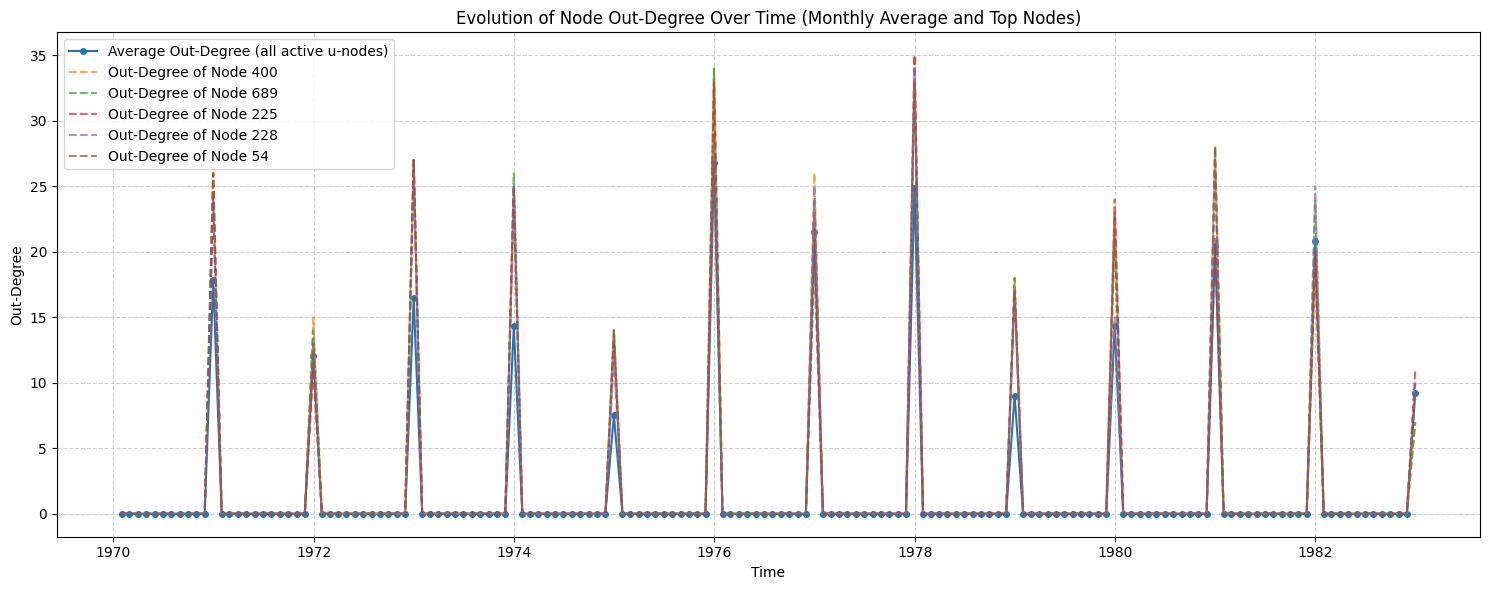

Insight: This plot shows how the average activity of source nodes changes over time, and highlights if specific 'influential' nodes have consistent or fluctuating activity patterns.

1.b. Burstiness Analysis: Distribution of Inter-Event Times for 'u' nodes


/home/s2516027/anaconda3/envs/kan_mammote/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


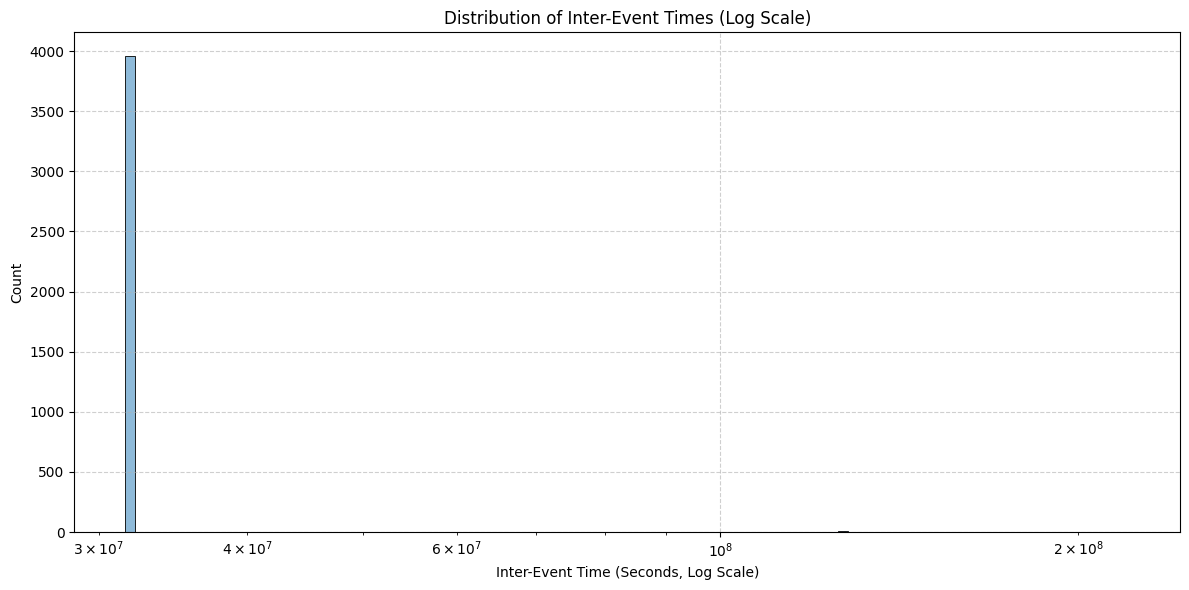

Mean Inter-Event Time: 1723588.85 seconds
Standard Deviation of Inter-Event Time: 7402260.38 seconds
Coefficient of Variation (CV) for Inter-Event Times: 4.29
Insight: CV > 1 suggests bursty activity, where events occur in clusters rather than uniformly.

--- 2. Deeper Feature Analysis & Interaction ---

2.a. Evolution of Edge Features Over Time Windows:


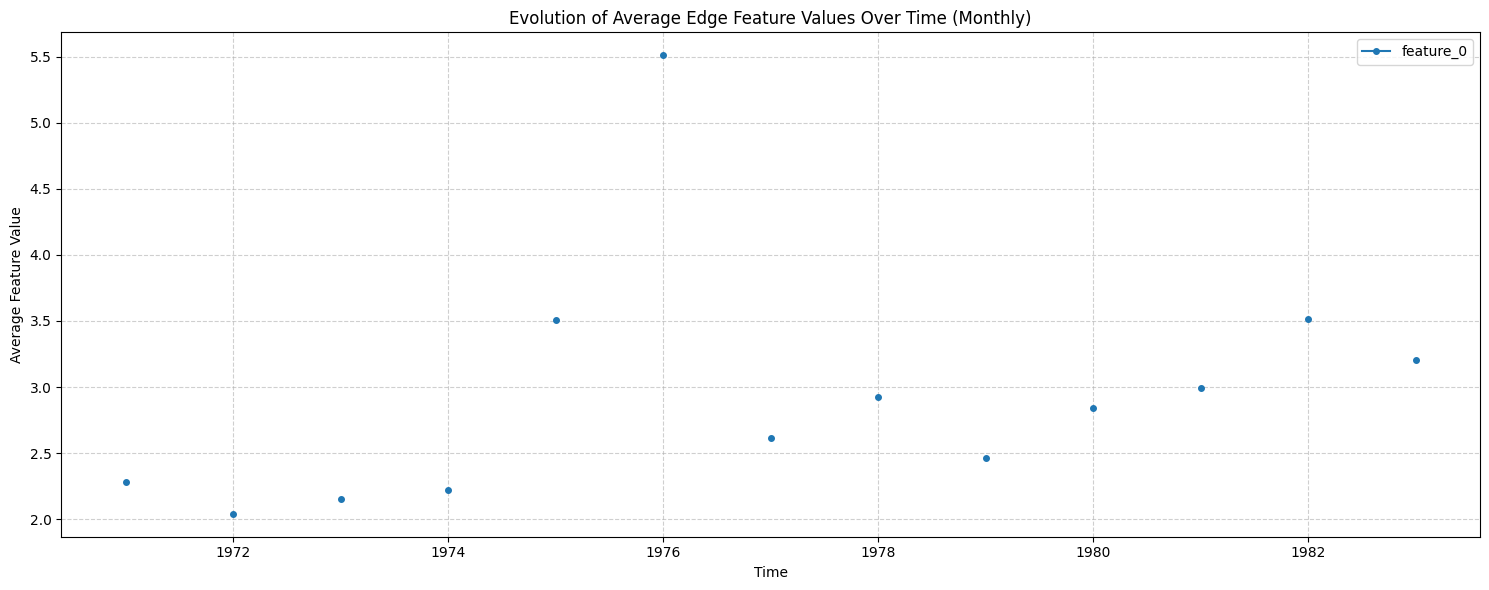

Insight: Observe if average edge features change significantly over time, potentially indicating shifts in interaction types or topics.
Skipping 2.b: No meaningful node features found for analysis (either not loaded or all zeros).

2.c. Feature Space Visualization (PCA):
Skipping Node Features PCA: Not enough dimensions (need at least 2) or features are all zeros.
Skipping Edge Features PCA: Not enough dimensions (need at least 2) or features are all zeros.

--- 3. Link Prediction Specific EDA (Conceptual Discussion) ---
These aspects are more about how data is prepared for modeling rather than direct plotting.

3.a. Negative Sampling Implications:
   - Given 'i' is often '1', the negative sampling for 'u' to 'i' links is simplified.
   - A 'negative' would be a (u_node, 1) pair that *did not* occur at a specific timestamp when it could have.
   - More broadly, if 'i' were diverse, negative samples would need careful consideration (e.g., sampling from non-existent edges, but filtering 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, timedelta
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- Configuration (matching previous simulation settings) ---
DATASET_NAME = "CanParl"
NUM_EDGES_SIMULATED = 50000
NUM_UNIQUE_NODES_SIMULATED = 10000
# IMPORTANT: Adjust these if your *actual* .npy files have different feature counts
NUM_EDGE_FEATURES_SIMULATED = 5 
NUM_NODE_FEATURES_SIMULATED = 10

ml_csv_path = f'processed_data/CanParl/ml_{DATASET_NAME}.csv'
ml_edge_features_path = f'processed_data/CanParl/ml_{DATASET_NAME}.npy'
ml_node_features_path = f'processed_data/CanParl/ml_{DATASET_NAME}_node.npy'

print(f"--- Starting Advanced EDA for {DATASET_NAME} Dataset ---")

# --- Load Data (assuming previous simulation/files exist) ---
try:
    df = pd.read_csv(ml_csv_path)
    df['timestamp_dt'] = pd.to_datetime(df['ts'], unit='s') # Convert timestamp
except FileNotFoundError:
    print(f"Error: {ml_csv_path} not found. Please run the previous data simulation code or ensure files are present.")
    exit()

edge_features = None
try:
    edge_features = np.load(ml_edge_features_path)
except FileNotFoundError:
    print(f"Warning: {ml_edge_features_path} not found. Proceeding without edge features.")

node_features = None
try:
    node_features = np.load(ml_node_features_path)
except FileNotFoundError:
    print(f"Warning: {ml_node_features_path} not found. Proceeding without node features.")

# --- Critical Check (re-confirming the 'i' column structure) ---
print("\n--- Re-confirming 'i' (destination node) column structure ---")
if df['i'].nunique() == 1 and df['i'].iloc[0] == 1:
    print("Confirmed: The 'i' column is consistently '1'. This implies interactions are with a single central entity.")
    print("Analysis will focus on 'u' node activity and their relationship to this central '1' node.")
    IS_SINGLE_TARGET_GRAPH = True
else:
    print("The 'i' column contains multiple unique destination nodes, proceeding as a typical directed graph.")
    IS_SINGLE_TARGET_GRAPH = False


# --- 1. Deeper Temporal Dynamics & Evolution ---

print("\n--- 1. Deeper Temporal Dynamics & Evolution ---")

# 1.a. Evolution of Node Activity (Out-Degree) Over Time Windows:
# (No change needed here, as it doesn't directly plot features by index)
print("\n1.a. Evolution of Node Activity (Out-Degree) Over Time Windows:")

time_windows = pd.date_range(start=df['timestamp_dt'].min(),
                             end=df['timestamp_dt'].max() + pd.DateOffset(months=1),
                             freq='M')

avg_out_degrees = []
window_dates = []

top_u_nodes = df['u'].value_counts().nlargest(5).index.tolist()
node_out_degrees_over_time = {node: [] for node in top_u_nodes}

for i in range(len(time_windows) - 1):
    start_window = time_windows[i]
    end_window = time_windows[i+1]
    
    window_df = df[(df['timestamp_dt'] >= start_window) & (df['timestamp_dt'] < end_window)]
    
    if len(window_df) > 0:
        G_window = nx.DiGraph()
        G_window.add_nodes_from(pd.concat([window_df['u'], window_df['i']]).unique())
        G_window.add_edges_from(zip(window_df['u'], window_df['i']))
        
        window_out_degrees = {node: G_window.out_degree(node) for node in G_window.nodes() if node != 1}
        
        if window_out_degrees:
            avg_out_degrees.append(np.mean(list(window_out_degrees.values())))
        else:
            avg_out_degrees.append(0)
        
        window_dates.append(start_window)

        for node in top_u_nodes:
            node_out_degrees_over_time[node].append(G_window.out_degree(node) if node in G_window else 0)
    else:
        avg_out_degrees.append(0)
        window_dates.append(start_window)
        for node in top_u_nodes:
             node_out_degrees_over_time[node].append(0)

plt.figure(figsize=(15, 6))
plt.plot(window_dates, avg_out_degrees, marker='o', linestyle='-', markersize=4, label='Average Out-Degree (all active u-nodes)')
for node_id, degrees in node_out_degrees_over_time.items():
    plt.plot(window_dates, degrees, linestyle='--', alpha=0.7, label=f'Out-Degree of Node {node_id}')

plt.title('Evolution of Node Out-Degree Over Time (Monthly Average and Top Nodes)')
plt.xlabel('Time')
plt.ylabel('Out-Degree')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
print("Insight: This plot shows how the average activity of source nodes changes over time, and highlights if specific 'influential' nodes have consistent or fluctuating activity patterns.")


# 1.b. Burstiness Analysis of Events (Inter-Event Times for 'u' nodes)
# (No change needed here)
print("\n1.b. Burstiness Analysis: Distribution of Inter-Event Times for 'u' nodes")

inter_event_times_seconds = []
for u_node in df['u'].unique():
    node_events = df[df['u'] == u_node].sort_values('timestamp_dt')
    if len(node_events) > 1:
        deltas = node_events['timestamp_dt'].diff().dropna().dt.total_seconds()
        inter_event_times_seconds.extend(deltas.tolist())

if inter_event_times_seconds:
    plt.figure(figsize=(12, 6))
    sns.histplot(inter_event_times_seconds, bins=100, kde=True, log_scale=True)
    plt.title('Distribution of Inter-Event Times (Log Scale)')
    plt.xlabel('Inter-Event Time (Seconds, Log Scale)')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    mean_iet = np.mean(inter_event_times_seconds)
    std_iet = np.std(inter_event_times_seconds)
    cv = std_iet / mean_iet
    print(f"Mean Inter-Event Time: {mean_iet:.2f} seconds")
    print(f"Standard Deviation of Inter-Event Time: {std_iet:.2f} seconds")
    print(f"Coefficient of Variation (CV) for Inter-Event Times: {cv:.2f}")
    if cv > 1:
        print("Insight: CV > 1 suggests bursty activity, where events occur in clusters rather than uniformly.")
    elif cv < 1:
        print("Insight: CV < 1 suggests more regular/periodic activity.")
    else:
        print("Insight: CV ≈ 1 suggests Poisson-like (random) activity.")
else:
    print("Not enough data to perform inter-event time analysis.")


# --- 2. Deeper Feature Analysis & Interaction ---

print("\n--- 2. Deeper Feature Analysis & Interaction ---")

# 2.a. Evolution of Edge Features Over Time Windows
if edge_features is not None and edge_features.shape[1] > 0 and not np.all(edge_features == 0):
    print("\n2.a. Evolution of Edge Features Over Time Windows:")
    
    # --- FIX APPLIED HERE ---
    # Determine the actual number of features to plot based on the loaded array
    features_to_plot = min(edge_features.shape[1], 3) # Plot up to 3 features, or less if fewer exist
    
    feature_means_over_time = {f'feature_{j}': [] for j in range(features_to_plot)}
    
    for i in range(len(time_windows) - 1):
        start_window = time_windows[i]
        end_window = time_windows[i+1]
        
        window_df_indices = df[(df['timestamp_dt'] >= start_window) & (df['timestamp_dt'] < end_window)]['idx'].values
        
        if len(window_df_indices) > 0:
            window_edge_features = edge_features[window_df_indices, :]
            for j in range(features_to_plot):
                feature_means_over_time[f'feature_{j}'].append(np.mean(window_edge_features[:, j]))
        else:
            for j in range(features_to_plot):
                feature_means_over_time[f'feature_{j}'].append(np.nan)

    plt.figure(figsize=(15, 6))
    for feature_name, means in feature_means_over_time.items():
        plt.plot(window_dates, means, marker='o', linestyle='-', markersize=4, label=feature_name)

    plt.title('Evolution of Average Edge Feature Values Over Time (Monthly)')
    plt.xlabel('Time')
    plt.ylabel('Average Feature Value')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("Insight: Observe if average edge features change significantly over time, potentially indicating shifts in interaction types or topics.")
else:
    print("Skipping 2.a: No meaningful edge features found for analysis (either not loaded or all zeros).")


# 2.b. Correlation Between Node Features and Activity (e.g., Out-Degree)
# (No change needed here, as it uses the feature array directly)
if node_features is not None and node_features.shape[1] > 0 and not np.all(node_features == 0):
    print("\n2.b. Correlation between Node Features and Node Activity (Static Out-Degree):")

    G_full = nx.DiGraph()
    G_full.add_nodes_from(pd.concat([df['u'], df['i']]).unique())
    G_full.add_edges_from(zip(df['u'], df['i']))

    node_degrees_df = pd.DataFrame(G_full.out_degree(), columns=['node_id', 'out_degree'])
    node_degrees_df = node_degrees_df[node_degrees_df['node_id'] != 1]

    nodes_with_features = [node for node in node_degrees_df['node_id'].unique() if node < node_features.shape[0]]
    if len(nodes_with_features) == 0:
        print("No nodes found with corresponding features for correlation analysis.")
    else:
        node_features_df = pd.DataFrame(node_features[nodes_with_features], index=nodes_with_features)
        node_features_df.index.name = 'node_id'

        merged_df = node_degrees_df.set_index('node_id').join(node_features_df)
        merged_df = merged_df.dropna()

        if not merged_df.empty:
            plt.figure(figsize=(10, 7))
            sns.scatterplot(x='out_degree', y=0, data=merged_df)
            plt.title('Out-Degree vs. Node Feature 0')
            plt.xlabel('Out-Degree')
            plt.ylabel('Node Feature 0 Value')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

            print("Correlation matrix between Out-Degree and Node Features (Top 3 features):")
            # --- FIX APPLIED HERE (Minor adjustment for features in corr matrix) ---
            # Ensure we only try to plot columns that actually exist in merged_df
            available_features = [col for col in range(node_features.shape[1]) if col in merged_df.columns]
            features_for_corr_plot = available_features[:min(len(available_features), 3)]
            
            if features_for_corr_plot:
                correlation_matrix = merged_df[['out_degree'] + features_for_corr_plot].corr()
                print(correlation_matrix)
            else:
                print("Not enough node features to compute correlation matrix for multiple features.")
            print("Insight: Look for strong positive or negative correlations. E.g., if a high value in a certain node feature correlates with higher out-degree, it suggests that feature indicates more active nodes.")
        else:
            print("Merged DataFrame for correlation is empty. Check node ID alignment and feature availability.")
else:
    print("Skipping 2.b: No meaningful node features found for analysis (either not loaded or all zeros).")


# 2.c. Feature Space Visualization with Dimensionality Reduction (PCA)
if (node_features is not None and node_features.shape[1] > 0 and not np.all(node_features == 0)) or \
   (edge_features is not None and edge_features.shape[1] > 0 and not np.all(edge_features == 0)):
    print("\n2.c. Feature Space Visualization (PCA):")

    # Node Features PCA
    # --- FIX APPLIED HERE (Ensure n_components is not greater than actual feature count) ---
    if node_features is not None and node_features.shape[1] >= 2 and not np.all(node_features == 0):
        print("   - Node Feature Space:")
        scaler = StandardScaler()
        scaled_node_features = scaler.fit_transform(node_features)
        
        # Adjust n_components based on actual feature count
        n_components_node_pca = min(node_features.shape[1], 2) 
        pca_node = PCA(n_components=n_components_node_pca)
        node_pca_components = pca_node.fit_transform(scaled_node_features)
        
        plt.figure(figsize=(10, 8))
        num_nodes_for_coloring = node_pca_components.shape[0]
        simulated_node_metadata = np.random.randint(0, 3, num_nodes_for_coloring)
        
        sns.scatterplot(x=node_pca_components[:, 0], y=node_pca_components[:, 1] if n_components_node_pca > 1 else np.zeros_like(node_pca_components[:, 0]), 
                        hue=simulated_node_metadata, palette='viridis', legend='full', alpha=0.7)
        
        plt.title('Node Features PCA (Colored by Simulated Party)')
        plt.xlabel(f'Principal Component 1 ({pca_node.explained_variance_ratio_[0]*100:.1f}%)')
        if n_components_node_pca > 1:
            plt.ylabel(f'Principal Component 2 ({pca_node.explained_variance_ratio_[1]*100:.1f}%)')
        else:
            plt.ylabel('Zero (Only 1 PC Available)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        print("Insight: Look for clusters. If nodes of the same 'party' (simulated here) cluster together, it suggests node features capture meaningful groupings.")

    else:
        print("Skipping Node Features PCA: Not enough dimensions (need at least 2) or features are all zeros.")

    # Edge Features PCA
    # --- FIX APPLIED HERE (Ensure n_components is not greater than actual feature count) ---
    if edge_features is not None and edge_features.shape[1] >= 2 and not np.all(edge_features == 0):
        print("   - Edge Feature Space:")
        scaler = StandardScaler()
        scaled_edge_features = scaler.fit_transform(edge_features)
        
        # Adjust n_components based on actual feature count
        n_components_edge_pca = min(edge_features.shape[1], 2)
        pca_edge = PCA(n_components=n_components_edge_pca)
        edge_pca_components = pca_edge.fit_transform(scaled_edge_features)

        plt.figure(figsize=(10, 8))
        num_edges_for_coloring = edge_pca_components.shape[0]
        simulated_edge_metadata = np.random.randint(0, 4, num_edges_for_coloring)
        
        sns.scatterplot(x=edge_pca_components[:, 0], y=edge_pca_components[:, 1] if n_components_edge_pca > 1 else np.zeros_like(edge_pca_components[:, 0]), 
                        hue=simulated_edge_metadata, palette='magma', legend='full', alpha=0.7)
        
        plt.title('Edge Features PCA (Colored by Simulated Speech Type)')
        plt.xlabel(f'Principal Component 1 ({pca_edge.explained_variance_ratio_[0]*100:.1f}%)')
        if n_components_edge_pca > 1:
            plt.ylabel(f'Principal Component 2 ({pca_edge.explained_variance_ratio_[1]*100:.1f}%)')
        else:
            plt.ylabel('Zero (Only 1 PC Available)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        print("Insight: Clusters in edge feature space might indicate distinct types of interactions or topics of discussion.")
    else:
        print("Skipping Edge Features PCA: Not enough dimensions (need at least 2) or features are all zeros.")
else:
    print("Skipping 2.c: No meaningful node or edge features found for dimensionality reduction.")


# --- 3. Link Prediction Specific EDA ---
print("\n--- 3. Link Prediction Specific EDA (Conceptual Discussion) ---")
print("These aspects are more about how data is prepared for modeling rather than direct plotting.")

print("\n3.a. Negative Sampling Implications:")
print("   - Given 'i' is often '1', the negative sampling for 'u' to 'i' links is simplified.")
print("   - A 'negative' would be a (u_node, 1) pair that *did not* occur at a specific timestamp when it could have.")
print("   - More broadly, if 'i' were diverse, negative samples would need careful consideration (e.g., sampling from non-existent edges, but filtering out edges that occurred at other times).")
print("   - For temporal graphs, defining 'non-existent' is tricky: is it 'never existed' or 'not existing at this moment'?")
print("   - The strategy for negative sampling (random, structural, time-aware) significantly impacts link prediction evaluation.")

print("\n3.b. Adjacency Matrix Evolution (Conceptual):")
print("   - For a general graph, visualizing adjacency matrix heatmaps over time (e.g., monthly snapshots) can show how connectivity patterns change.")
print("   - For CanParl with 'i=1', the adjacency matrix is essentially a vector indicating which 'u' nodes were active against '1' at a given time.")
print("   - Useful for very small graphs to see interaction patterns directly, but impractical for large ones.")

print("\n3.c. Link Lifespan / Persistence (Conceptual):")
print("   - This involves analyzing sequences of interactions for the same (u, i) pair (if 'i' were diverse).")
print("   - Example: If MP A votes with Bill B multiple times, what's the average time between their votes?")
print("   - For CanParl ('u' to '1'), it's about the persistence of a 'u' node's activity towards the central '1' node.")
print("   - Insight: Helps understand how 'strong' or 'persistent' an interaction is, influencing memory mechanisms in TGNs.")


# --- 4. Visualizing the Complexities (Interactive Tools Mention) ---
print("\n--- 4. Visualizing Complexities (Beyond Static Plots) ---")
print("For truly understanding large, dynamic graphs, interactive visualization tools are essential:")
print("   - Pyvis: Good for generating interactive HTML files of subgraphs, allowing zoom, pan, and node/edge inspection.")
print("   - Plotly/Dash: For building custom interactive dashboards where you can filter by time, select nodes, and see their temporal activity.")
print("   - Gephi: A powerful standalone graph visualization software with dynamic graph plugins for animating temporal evolution. Requires exporting data in specific formats.")
print("These tools allow exploration of the graph's evolution, highlighting active nodes/edges in specific time windows.")


print("\n--- Advanced EDA Complete ---")
print("Next steps would involve translating these insights into hypotheses for model design and interpreting model results.")